VectorAdam for Rotation Equivariant Geometry Optimization
======================================

This is an example on how to use VectorAdam for Laplacian smoothing in 2D.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import math
from util import *
from vectoradam import * 

# Laplacian Smoothing in 2D 

### 1. Create the mesh.

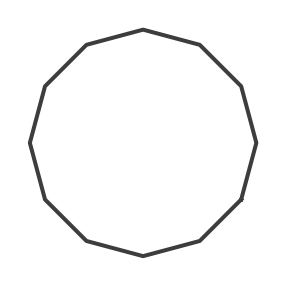

In [2]:
n = 12
v1,l1 = create_circle(n_points=n, noise_level=0)
v2,l2 = create_circle(n_points=n, noise_level=0)
eps = 1
x_lim = [np.min(v1[:,0]) - eps, np.max(v1[:,0]) + eps]
y_lim = [np.min(v1[:,1]) - eps, np.max(v1[:,1]) + eps]

# keep track of meshes for later plotting
data= {}
data['original mesh'] = (v1, l1)

# plot the original mesh 
plot_mesh2d(v1,l1,x_lim=x_lim, y_lim=y_lim, showfig=True)

In [3]:
# Set optimizer hyperparameters
lr = 0.5
betas = (0.9, 0.999)
eps = 1e-8

In [4]:
# Torch the arrays
v1 = torch.from_numpy(v1).to(torch.float32).cuda()
l1 = torch.from_numpy(l1).cuda()
v2 = torch.from_numpy(v2).to(torch.float32).cuda()
l2 = torch.from_numpy(l2).cuda()
v1.requires_grad = True
v2.requires_grad = True

In [5]:
# Initialize VectorAdam optimizers
regadam = VectorAdam([{'params': v1, 'axis': None}], lr=lr, betas=betas, eps=eps)
vadam = VectorAdam([{'params': v2, 'axis': -1}], lr=lr, betas=betas, eps=eps)

### 2. One Optimization step with Adam

In [6]:
# One optimization step with Adam
# Laplacian smoothing loss
regadam.zero_grad()
vbf = v1.detach().cpu()
L1 = laplacian_uniform_2d(v1,l1)
loss1 = (v1 * (L1 @ v1)).mean()
loss1.backward()
regadam.step()
vaf = v1
adam_step = vaf-vbf.cuda()

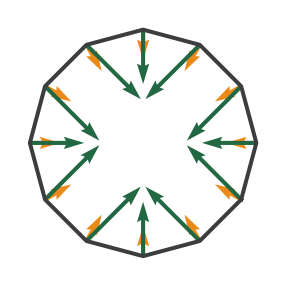

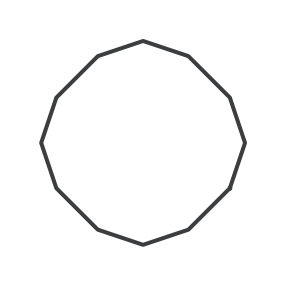

In [7]:
# Save the results from Adam
data["radam grad"] = -adam_step.detach().cpu().numpy()
data["original grad"] = v1.grad.detach().cpu().numpy()
data["radam mesh step1"] = (v1.detach().cpu().numpy(), l1.detach().cpu().numpy())

fig, ax = plot_mesh2d(data['original mesh'][0], data['original mesh'][1], 
                      x_lim = x_lim,
                      y_lim = y_lim,
                      return_ax = True)
ax.quiver(data['original mesh'][0][:,0], data['original mesh'][0][:,1], 
          -data["original grad"][:,0], -data["original grad"][:,1], scale=1.0, color="#EC8A19", width=0.015)
ax.quiver(data['original mesh'][0][:,0], data['original mesh'][0][:,1], 
          -data["radam grad"][:,0], -data["radam grad"][:,1], scale=2.5, color="#226843", width=0.015)
plt.show()

# step 1 image 
data[f'radam mesh step1'] = (v1.detach().cpu().numpy(), l1.detach().cpu().numpy())
plot_mesh2d(data[f'radam mesh step1'][0], data[f'radam mesh step1'][1], 
            x_lim = x_lim,
            y_lim = y_lim,
            showfig=True)

### 3. One optimization step with VectorAdam

In [8]:
vadam.zero_grad()
vbf = v2.detach().cpu()
L2 = laplacian_uniform_2d(v2,l2)
loss2 = (v2 * (L2 @ v2)).mean()
loss2.backward()
vadam.step()
vaf = v2
vadam_step = vaf-vbf.cuda()
data["vadam grad"] = -vadam_step.detach().cpu().numpy()
data["vadam mesh step1"] = (v2.detach().cpu().numpy(), l2.detach().cpu().numpy())

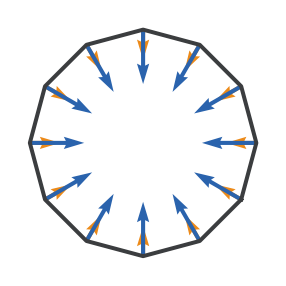

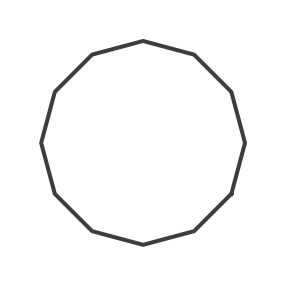

In [9]:
# plot 
# gradient image
fig, ax = plot_mesh2d(data['original mesh'][0], data['original mesh'][1], 
                      x_lim = x_lim,
                      y_lim = y_lim,
                      return_ax = True)
ax.quiver(data['original mesh'][0][:,0], data['original mesh'][0][:,1], 
          -data["original grad"][:,0], -data["original grad"][:,1], scale=1.0, color="#EC8A19", width=0.015)
ax.quiver(data['original mesh'][0][:,0], data['original mesh'][0][:,1], 
          -data["vadam grad"][:,0], -data["vadam grad"][:,1], scale=2.5, color="#2A63AD", width=0.015)
plt.show()

# step 1 image 
data[f'vadam mesh step1'] = (v2.detach().cpu().numpy(), l2.detach().cpu().numpy())
plot_mesh2d(data[f'vadam mesh step1'][0], data[f'vadam mesh step1'][1], 
            x_lim = x_lim,
            y_lim = y_lim,
            showfig=True)

### 4. Five optimization steps with Adam

100%|██████████| 5/5 [00:00<00:00, 393.43it/s]


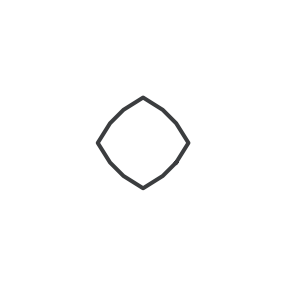

In [10]:
# optimization loop
# regular adam
steps = 5
from tqdm import tqdm
for i in tqdm(range(steps)):
    regadam.zero_grad()
    #laplacian loss
    L1 = laplacian_uniform_2d(v1,l1)
    loss1 = (v1 * (L1 @ v1)).mean()
    loss1.backward()
    regadam.step()

data[f'radam mesh step{steps}'] = (v1.detach().cpu().numpy(), l1.detach().cpu().numpy())
plot_mesh2d(data[f'radam mesh step{steps}'][0], data[f'radam mesh step{steps}'][1], 
            x_lim = x_lim,
            y_lim = y_lim,
            showfig=True)

100%|██████████| 5/5 [00:00<00:00, 442.19it/s]


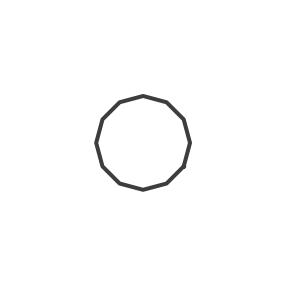

In [11]:
# vector adam
steps = 5
for i in tqdm(range(steps)):
    vadam.zero_grad()
    #laplacian loss
    L2 = laplacian_uniform_2d(v2,l2)
    loss2 = (v2 * (L2 @ v2)).mean()
    loss2.backward()
    vadam.step()

data[f'vadam mesh step{steps}'] = (v2.detach().cpu().numpy(), l2.detach().cpu().numpy())
plot_mesh2d(data[f'vadam mesh step{steps}'][0], data[f'vadam mesh step{steps}'][1], 
            x_lim = x_lim,
            y_lim = y_lim,
            showfig=True)